# MACD

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from MACD import MACD
from util.Save_result_return import save_to_csv


## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = MACD

In [6]:
account_size = 10000

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/100,  commission=0.0002 )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.325798
Equity Final [$]                 10209.073809
Equity Peak [$]                  10691.042766
Return [%]                           2.090738
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.103451
Volatility (Ann.) [%]                2.055083
Sharpe Ratio                         0.050339
Sortino Ratio                         0.07191
Calmar Ratio                         0.011794
Max. Drawdown [%]                   -8.771694
Avg. Drawdown [%]                   -0.981102
Max. Drawdown Duration     1880 days 00:00:00
Avg. Drawdown Duration      172 days 00:00:00
# Trades                                  399
Win Rate [%]                        34.085213
Best Trade [%]                      14.310774
Worst Trade [%]                     -9.067605
Avg. Trade [%]                    

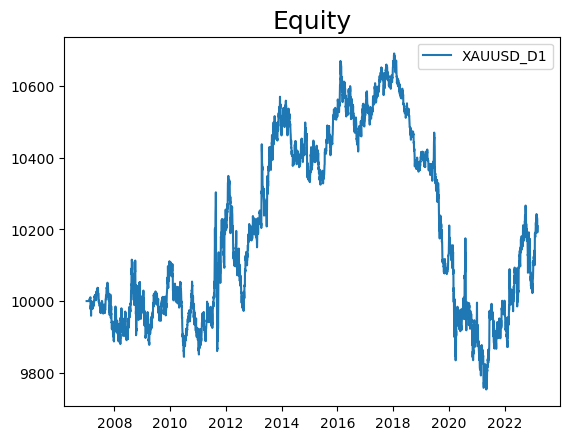

In [8]:
plot_equity_trades(result_D1['_equity_curve'],'XAUUSD_D1' , account_size)

### Save output

In [9]:
save_to_csv(result_D1, '../../out/Technical_Strategy/MACD/Backtest/result_D1.csv')  

## TF H4

In [10]:
Backtest_H4 = Backtest(XAUUSD['H4'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    99.86911
Equity Final [$]                 11615.774654
Equity Peak [$]                  12077.128397
Return [%]                          16.157747
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    0.751257
Volatility (Ann.) [%]                1.886914
Sharpe Ratio                         0.398141
Sortino Ratio                        0.601091
Calmar Ratio                         0.134465
Max. Drawdown [%]                   -5.587007
Avg. Drawdown [%]                   -0.283574
Max. Drawdown Duration     2351 days 16:00:00
Avg. Drawdown Duration       26 days 11:00:00
# Trades                                 1974
Win Rate [%]                        36.930091
Best Trade [%]                      11.513696
Worst Trade [%]                     -5.479481
Avg. Trade [%]                    

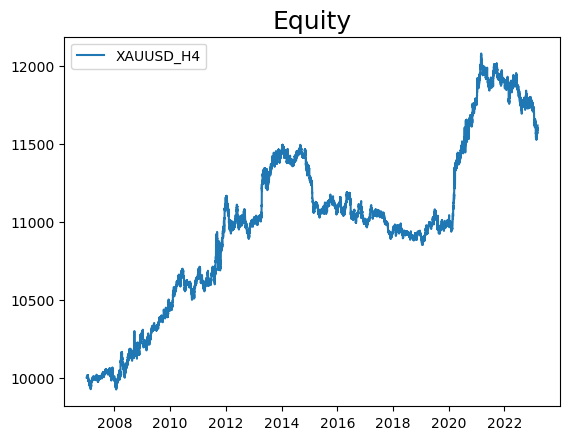

In [11]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4' , account_size)

### Save output

In [12]:
save_to_csv(result_H4, '../../out/Technical_Strategy/MACD//Backtest/result_H4.csv')  

## TF H1

In [13]:
Backtest_H1 = Backtest(XAUUSD['H1'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                    99.96529
Equity Final [$]                  9425.890186
Equity Peak [$]                  10305.263928
Return [%]                          -5.741098
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -0.295013
Volatility (Ann.) [%]                2.104571
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.558748
Avg. Drawdown [%]                   -0.487342
Max. Drawdown Duration     2943 days 00:00:00
Avg. Drawdown Duration       76 days 18:00:00
# Trades                                 7515
Win Rate [%]                        33.918829
Best Trade [%]                      13.180833
Worst Trade [%]                     -5.160029
Avg. Trade [%]                    

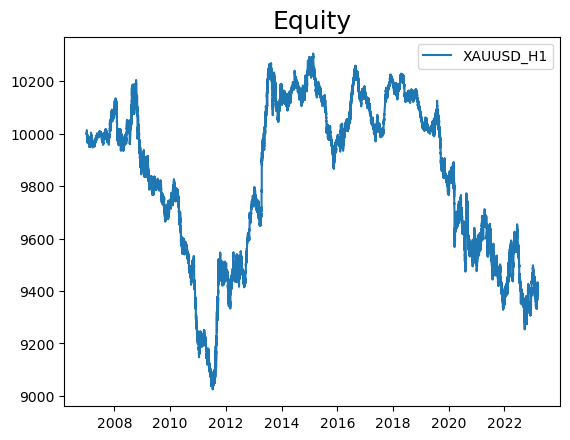

In [14]:
plot_equity_trades(result_H1['_equity_curve'], 'XAUUSD_H1', account_size)

### Save output

In [15]:
save_to_csv(result_H1, '../../out/Technical_Strategy/MACD/Backtest/result_H1.csv')  

## TF M30 

In [16]:
Backtest_M30 = Backtest(XAUUSD['M30'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   99.982585
Equity Final [$]                  4473.857765
Equity Peak [$]                  10004.459695
Return [%]                         -55.261422
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                   -3.939717
Volatility (Ann.) [%]                3.259565
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -56.336816
Avg. Drawdown [%]                   -8.053347
Max. Drawdown Duration     5911 days 07:00:00
Avg. Drawdown Duration      844 days 13:26:00
# Trades                                14965
Win Rate [%]                        31.673906
Best Trade [%]                       8.744542
Worst Trade [%]                     -4.175714
Avg. Trade [%]                    

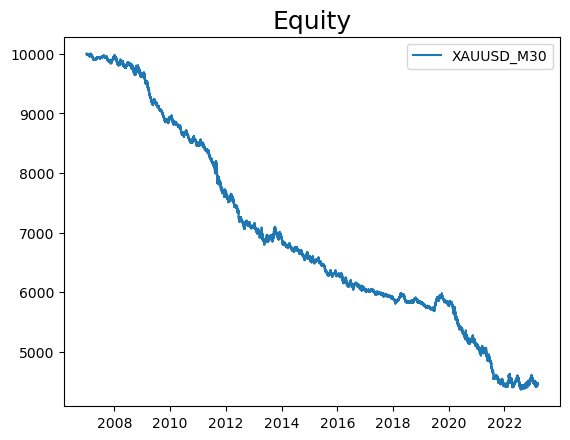

In [17]:
plot_equity_trades(result_M30['_equity_curve'], 'XAUUSD_M30', account_size)

### Save output

In [ ]:
save_to_csv(result_M30, '../../out/Technical_Strategy/MACD/Backtest/result_M30.csv')  